<a href="https://colab.research.google.com/github/nmoisseeva/rod/blob/main/iselle_winds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#June 1, 2022
#nadya.moisseeva@hawaii.edu
#This script analysis Iselle station wind data (model comparison)

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [ ]:
#----------------INPUT----------------
data_path = '/content/drive/MyDrive/data/rod/wind/'
fig_path = '/content/drive/MyDrive/colab/rod/fig/'
wrfout = '/content/drive/MyDrive/data/rod/winds_d03'
stations = ['hilo','hono','kahu','kane','lihu','molo', 'kona']
trials = ['era5', 'trial']
#The following stations have large gaps and are excluded: Kalaeola, Kona
#----------end of input---------------

In [ ]:
#load and format model data
model_dict = {}
for trial in trials:
  model_dict[trial] = {}
  for stn in stations:
    model_path = os.path.join(data_path, 'model', trial ,f'{stn.lower()}.d01.TS')
    if os.path.exists(model_path):
      model_data = pd.read_csv(model_path, skiprows=1, delim_whitespace=True, usecols=[1,7,8], names=['htime','u','v'])
      model_data['datetime'] = pd.to_datetime('2014-08-07 00:00:00') + pd.to_timedelta(model_data.htime, unit='H')
      model_data['wind_kt'] = (model_data.u**2 + model_data.v**2)**(0.5)
      model_data.drop(columns=['htime'], inplace=True)
      model_dict[trial][stn] = model_data

In [ ]:
model_dict[trial][stn]

,u,v,datetime,wind_kt
0,2.85335,-0.70644,2014-08-07 00:01:30.000000,2.939501
1,2.61093,-0.60264,2014-08-07 00:03:00.000000,2.679577
2,2.98143,-0.73816,2014-08-07 00:04:30.000000,3.071450
3,2.63542,-0.63247,2014-08-07 00:06:00.000000,2.710250
4,2.91323,-0.54778,2014-08-07 00:07:30.000000,2.964283
...,...,...,...,...
2395,-1.66309,0.17081,2014-08-09 11:54:00.007200,1.671839
2396,-1.55322,0.13988,2014-08-09 11:55:29.996400,1.559506
2397,-1.43020,0.10162,2014-08-09 11:57:00.003600,1.433806
2398,-1.29794,0.06028,2014-08-09 11:58:29.992800,1.299339


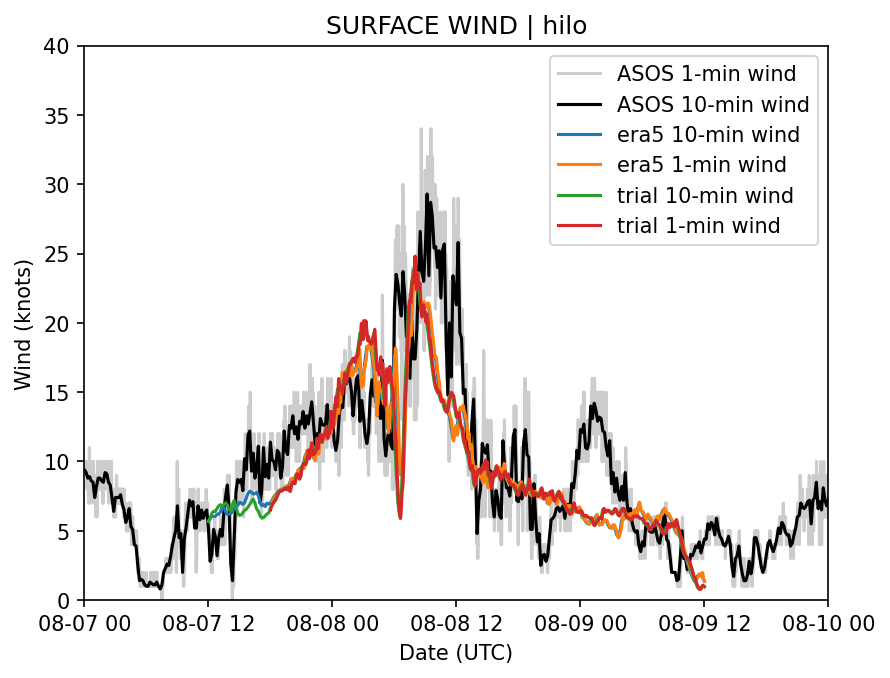

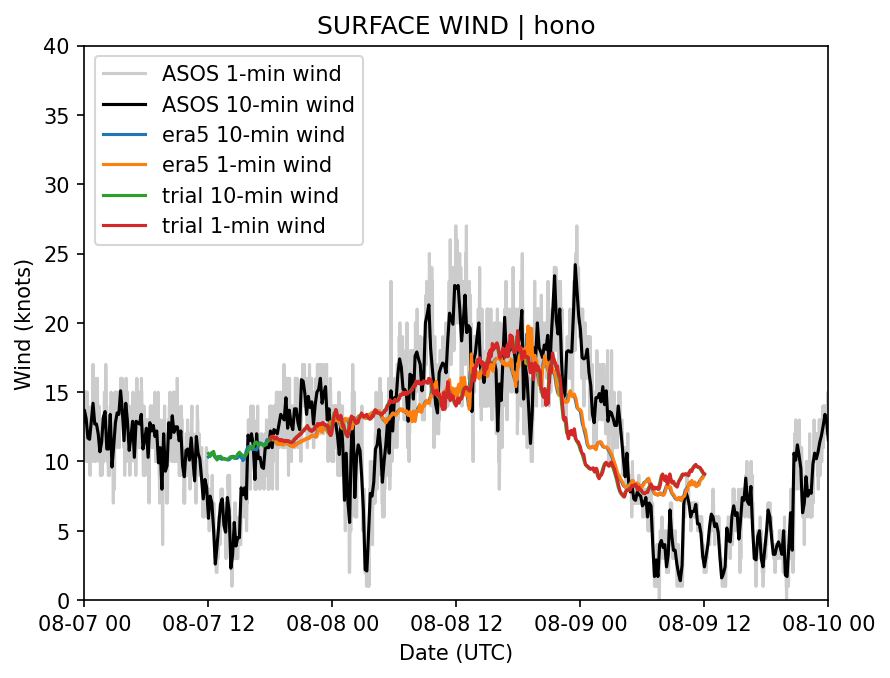

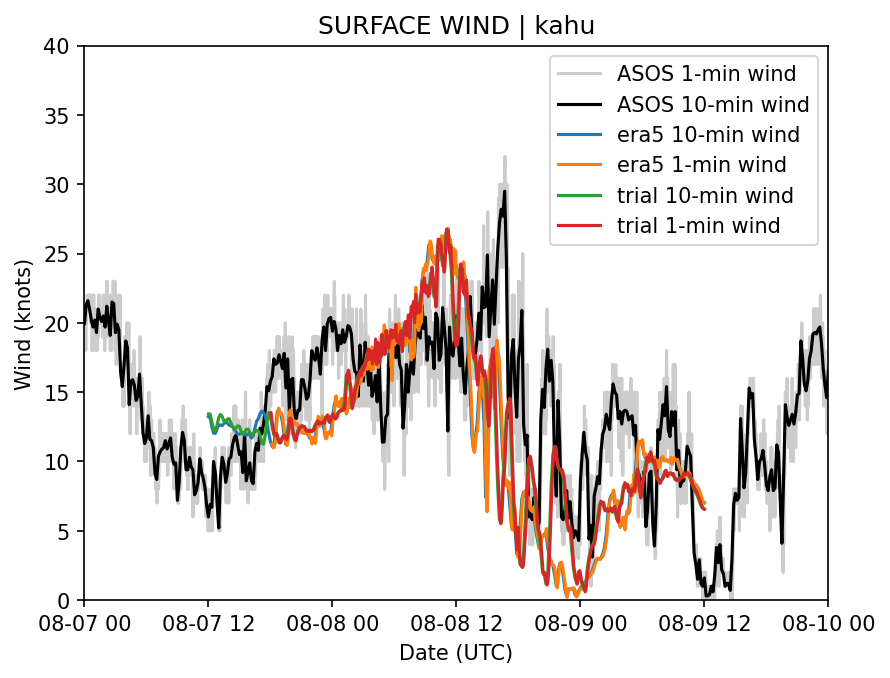

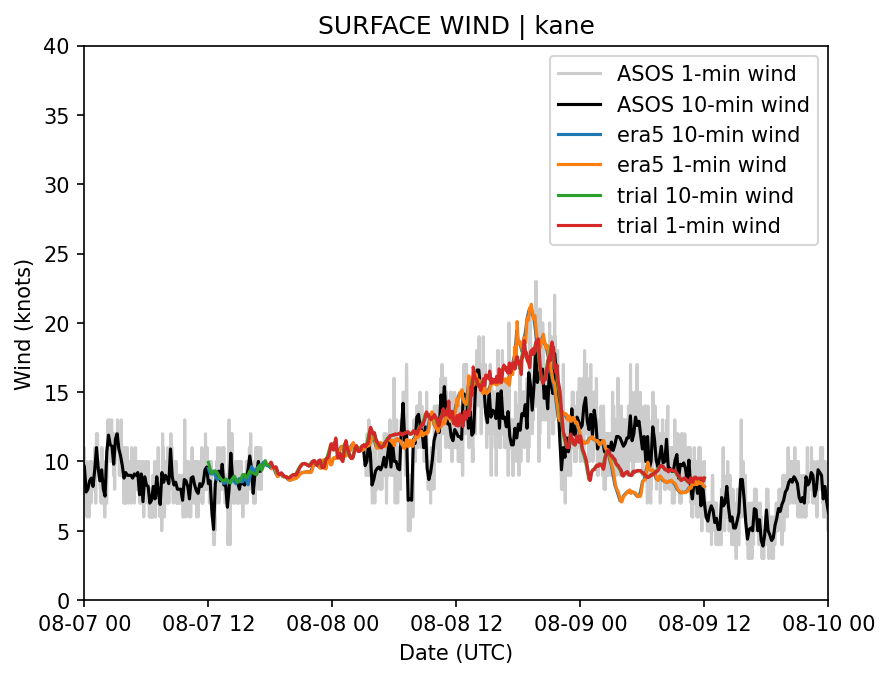

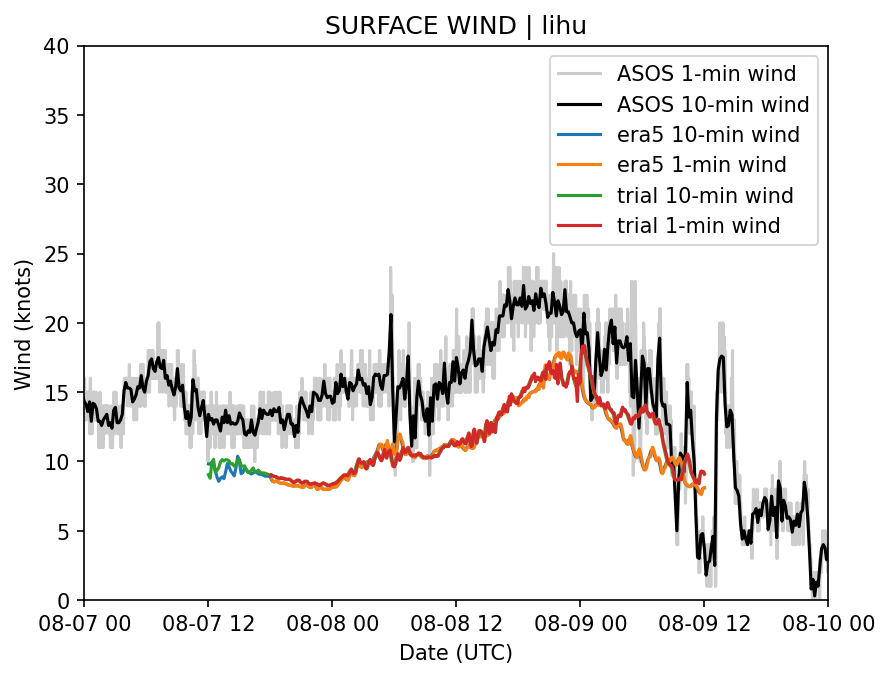

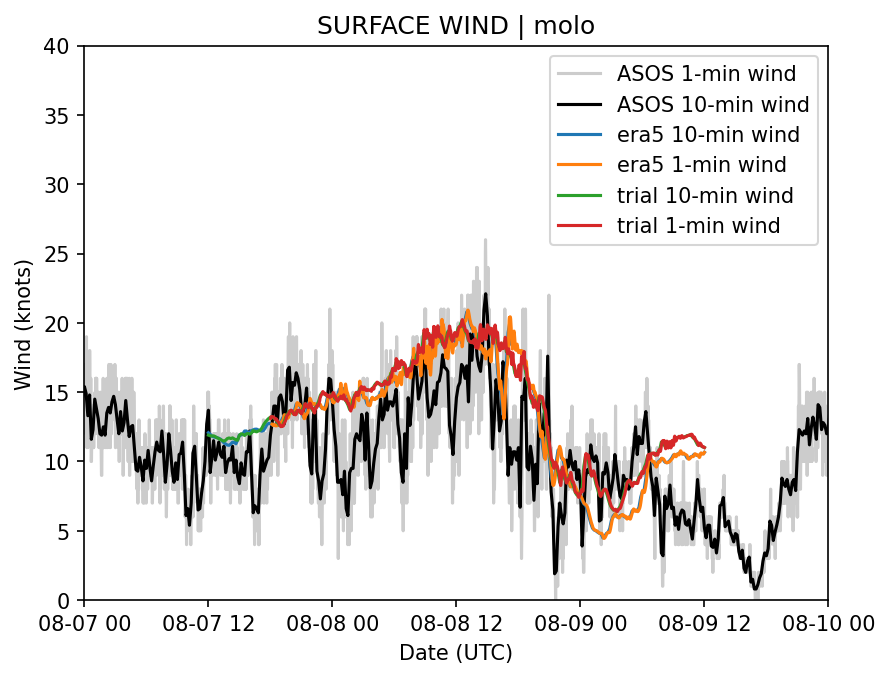

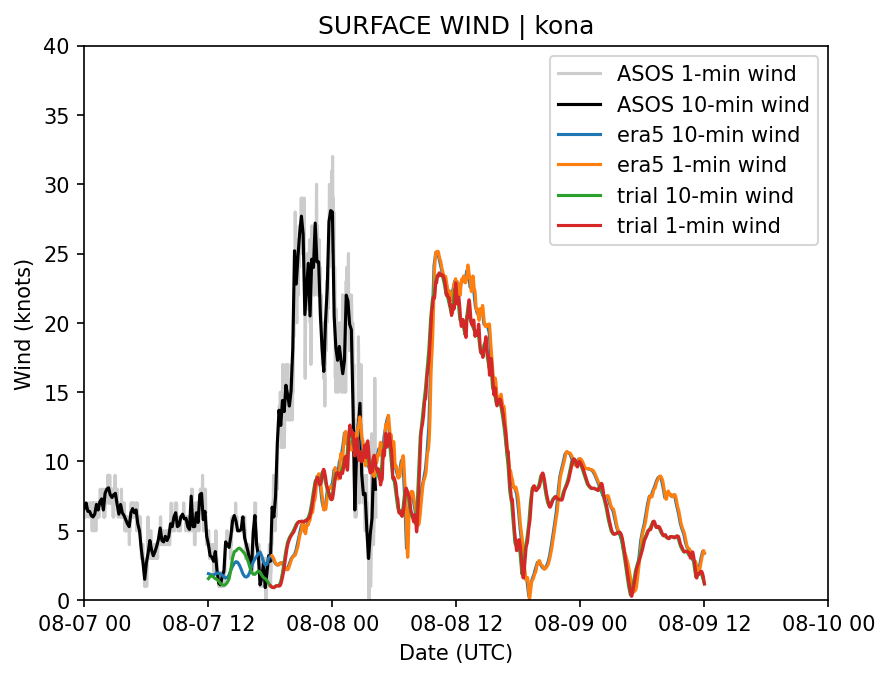

In [ ]:
#load and format observational data
stn_dict = {}
for stn in stations:
  stn_path = os.path.join(data_path, f'{stn}.txt')
  #stn_data = pd.read_csv(stn_path, parse_dates=[2], names=['station','station_name','datetime', 'wind_kt', 'junk'] )
  stn_data = pd.read_csv(stn_path, skiprows=1,parse_dates=[2], names=['station','station_name','datetime', 'wind_kt', 'junk'] )
  stn_data.drop(columns=['junk'], inplace=True)
  stn_data['wind_kt'].astype(float)
  stn_dict[stn] = stn_data
  resampled = stn_data.set_index('datetime').resample('10MIN').mean(numeric_only=True)

  # #if model data is available, call
  # try:
  #   resampled_model = model_dict[stn].set_index('datetime').resample('10MIN').mean()
  # except:
  #   print(f'No model data found for station: {stn}')


  #plot obs
  spinup = 12*6     #assuming 10min resampling
  plt.figure()
  ax = plt.gca()
  plt.plot(stn_dict[stn].datetime, stn_dict[stn].wind_kt, color='k',alpha=0.2, label='ASOS 1-min wind')
  plt.plot(resampled.index, resampled.wind_kt, color='k', label='ASOS 10-min wind')

  #plot modelled winds
  for trial in trials:
    if stn in model_dict[trial].keys():
      resampled_model = model_dict[trial][stn].set_index('datetime').resample('10MIN').mean()
      plt.plot(resampled_model.index[spinup:], resampled_model.wind_kt[spinup:], label=f'{trial} 10-min wind')
      plt.plot(model_dict[trial][stn].datetime[12*60:], model_dict[trial][stn].wind_kt[12*60:], label=f'{trial} 1-min wind')

  ax.set(title=f'SURFACE WIND | {stn}', ylabel='Wind (knots)', xlabel='Date (UTC)')
  plt.legend()

  ax.set(xlim=[dt.date(2014, 8, 7), dt.datetime(2014, 8, 10)], ylim = [0,40] )
  # plt.savefig(f'{data_path}/model/figs/{stn}.pdf')


In [ ]:
# from netCDF4 import Dataset
# from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy
# ncfile = Dataset(wrfout)
# x_y = ll_to_xy(ncfile, 19.72026, -155.04847)